In [2]:
import numpy as np
import pandas as pd
import luxpy as lp
from scipy.interpolate import CubicSpline
np.set_printoptions(suppress=False) 

import matplotlib.pyplot as plt

C:\Users\guym\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\guym\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### 1. import IES files

In [3]:
# pip install luxpy

In [4]:
ies = lp.toolboxes.iolidfiles.read_lamp_data('ies/1.ies')

In [5]:
ies.keys()

dict_keys(['datasource', 'name', 'version', 'lamps_num', 'lumens_per_lamp', 'candela_mult', 'v_angles_num', 'h_angles_num', 'photometric_type', 'units_type', 'width', 'length', 'height', 'ballast_factor', 'future_use', 'input_watts', 'v_angs', 'h_angs', 'lamp_cone_type', 'lamp_h_type', 'candela_values', 'candela_2d', 'v_same', 'h_same', 'intensity', 'map', 'norm_angs', 'Isym', 'theta', 'phi', 'values', 'Iv0'])

In [6]:
print(' luminaire width: ', ies['width'], '\n', 
      'luminaire length: ', ies['length'],'\n', 
      'luminaire height: ', ies['height'],'\n',
     'luminaire wattage: ', ies['input_watts'], '\n', 
      'candela multiplier: ', ies['candela_mult'])

 luminaire width:  1.47 
 luminaire length:  1.47 
 luminaire height:  0.2375 
 luminaire wattage:  69.6 
 candela multiplier:  1.032007


Key `candela_mult`, `v_angs`, `h_angs`, `candela_values` were used below.

#### There are three types of Luminiare testing methods - Indoor, Roadway and Floodlight 


#### a. This is the coordinate system when the fixture is tested as indoor / roadway luminiare

<img src="img/1_0.png" width="700">

#### b. This is the coordinate system when the fixture is tested as floodlight luminiare

<img src="img/1_2.png" width="450">

#### The following codes only apply to condition `a`, when the fixture is tested as indoor / roadway luminiare

#### 1.1 raw Intensity (candela) values

In [7]:
n_h_angles = len(ies['h_angs'])
n_v_angles = len(ies['v_angs'])

# create numpy array and insert intensity values(multiplied by candela_mult)
cd = np.zeros((n_h_angles, n_v_angles))

for i in range(n_h_angles):
    end_angles = n_v_angles*(i+1)
    cd[i] = ies['candela_values'][i*n_v_angles:end_angles]*ies['candela_mult']

In [8]:
cd.shape

(12, 74)

#### 1.2 broadcast intensity values to full 0-360° horizontal plane

* `Quadrilateral symmetric` horizontal testing angles within [0-90°]
* `Bilateral symmetric` horizontal testing angles angles within [0-180°]
* `Axial symmetric` horizontal testing angles angle = 0°
* `Asymetric` A complete set of horizontal testing angles from 0-360° (may or may not include 360°)

In [9]:
ies['h_angs']

array([ 0.,  5., 15., 25., 35., 45., 46., 55., 65., 75., 85., 90.])

In [10]:
def broadcast(cd, h_angs):
    
    if max(h_angs)==360: # asymmetric, 360° is included
        full_h_angs = h_angs
        cd_0_360 = cd
        
    elif max(h_angs) > 180: # asymmetric, 360° not included
        full_h_angs = np.append(h_angs,360) # add 360°
        cd_0_360 = np.vstack((cd, cd[0])) # copy intensity data @0° to 360°
    
    elif max(h_angs) == 90: # quadrilateral symmetric
        h_angs_1 = 180 - h_angs[0:-1] # angle for 90° - 180° plane
        h_angs_2 = 180 + h_angs[1:] # angle for 0° - 180° plane
        h_angs_3 = 360 - h_angs[0:-1] # angle for 180° - 360° plane
        full_h_angs = np.sort(np.concatenate((h_angs, h_angs_1, h_angs_2, h_angs_3))) # full horizontal angles
        cd_90_180 = cd[:-1][::-1]  # intensity value for 90° - 180° plane
        cd_0_180 = np.vstack((cd, cd_90_180))  # intensity value for 0° - 180° plane
        cd_180_360 = cd_0_180[:-1][::-1]   # intensity value for 180° - 360° plane
        cd_0_360 = np.vstack((cd_0_180, cd_180_360))  # intensity value for 0° - 360° plane
        
    elif max(h_angs) == 180: # bilateral symmetric
        h_angs_1 = 360 - h_angs[:-1]
        full_h_angs = np.sort(np.concatenate((h_angs, h_angs_1))) # full horizontal angles
        cd_180_360 = cd[:-1][::-1] # intensity value for 180° - 360° plane
        cd_0_360 = np.vstack((cd, cd_180_360))  # intensity value for 0° - 360° plane
        
    elif max(h_angs) == 0: # axial symmetric
        full_h_angs = np.arange(0,360+1, 22.5) # standard indoor luminaire horizontal testing intervals
        cd_0_360 = np.repeat(cd, len(full_h_angs), axis=0) # intensity value for 0° - 360° plane 
        # changed from np.repeat([cd], len(full_h_angs), axis=0)
        
    return cd_0_360, full_h_angs
    

In [11]:
full_cd, full_h_angs = broadcast(cd, ies['h_angs'])

In [12]:
display(full_cd, full_h_angs)

array([[401.450723, 404.546744, 409.706779, ...,  15.480105,  15.480105,
         15.480105],
       [401.450723, 404.546744, 409.706779, ...,  15.480105,  15.480105,
         15.480105],
       [401.450723, 403.514737, 409.706779, ...,  15.480105,  15.480105,
         15.480105],
       ...,
       [401.450723, 403.514737, 409.706779, ...,  15.480105,  15.480105,
         15.480105],
       [401.450723, 404.546744, 409.706779, ...,  15.480105,  15.480105,
         15.480105],
       [401.450723, 404.546744, 409.706779, ...,  15.480105,  15.480105,
         15.480105]])

array([  0.,   5.,  15.,  25.,  35.,  45.,  46.,  55.,  65.,  75.,  85.,
        90.,  95., 105., 115., 125., 134., 135., 145., 155., 165., 175.,
       180., 185., 195., 205., 215., 225., 226., 235., 245., 255., 265.,
       270., 275., 285., 295., 305., 314., 315., 325., 335., 345., 355.,
       360.])

-------------------------------------------------------------------------------

#### 1.3 Interpolate intensity value if raw data is not evenly distributed, delete duplicated data at horizontal 360° 

In [13]:
def interpolate(cd, h_angs, v_angs):
    
    if all(np.diff(h_angs)==np.diff(h_angs)[0]): # horizontal angles have equal intervals
        cd_inter = cd[:-1].transpose() # delete data @360°, transpose data for future use
        h_angs_inter = h_angs
        
    else: # horizontal angles have unequal intervals
        min_step = np.diff(h_angs).min() # find the minimum interval
        cd_T = cd.transpose() # transpose data for calculation
        
        if np.sum(np.diff(ies['h_angs'])%min_step) == 0:
            h_angs_inter = np.arange(0, 361, step=min_step) # create an array of angles with equal interval            
            cd_inter = np.zeros((len(v_angs), len(h_angs_inter))) 
            for i in range(len(v_angs)):
                cd_inter[i] = np.interp(h_angs_inter, h_angs, cd_T[i]) # linear interpolation
                
        else:
            h_angs_inter = np.arange(0, 361, step=1) # create an array of angles with equal interval
            cd_inter = np.zeros((len(v_angs), len(h_angs_inter))) 
            for i in range(len(v_angs)):
                # f = CubicSpline(h_angs, cd_T[i], bc_type='natural') # Cubic spline interpolation
                # cd_inter[i] = f(h_angs_inter)
                cd_inter[i] = np.interp(h_angs_inter, h_angs, cd_T[i]) # linear interpolation
            
        cd_inter = np.delete(cd_inter, -1, axis=1) # delete data @360°
        
    return cd_inter, h_angs_inter

In [14]:
cd_inter, h_angs_inter = interpolate(full_cd, full_h_angs, ies['v_angs'])

In [15]:
cd_inter.shape

(74, 360)

In [40]:
cd_inter

array([[401.450723, 401.450723, 401.450723, ..., 401.450723, 401.450723,
        401.450723],
       [404.546744, 404.546744, 404.546744, ..., 404.546744, 404.546744,
        404.546744],
       [409.706779, 409.706779, 409.706779, ..., 409.706779, 409.706779,
        409.706779],
       ...,
       [ 15.480105,  15.480105,  15.480105, ...,  15.480105,  15.480105,
         15.480105],
       [ 15.480105,  15.480105,  15.480105, ...,  15.480105,  15.480105,
         15.480105],
       [ 15.480105,  15.480105,  15.480105, ...,  15.480105,  15.480105,
         15.480105]])

#### 1.4 Intensity (candelapower at Point A, B, C)

#### Point A: Intensity(cd, candlepower) at (0°,0°)

In [41]:
h_index, = np.where(h_angs_inter ==0)
v_index, = np.where(ies['v_angs'] ==0)

In [42]:
cd_0_0 = cd_inter[v_index][0][h_index][0]

In [43]:
cd_0_0

401.450723

#### Point B: Intensity(cd, candlepower) at (45°,0°)

In [44]:
h_index, = np.where(h_angs_inter == 0)
v_index, = np.where(ies['v_angs'] ==45)

In [45]:
cd_45_0 = cd_inter[v_index][0][h_index][0]

In [46]:
cd_45_0

1095.9914339999998

#### Point C: Intensity(cd, candlepower) at (54.73°,45°)

In [47]:
h_index, = np.where(h_angs_inter ==45)
v_index, = np.where(ies['v_angs'] ==52.5)

In [48]:
cd_525_45 = cd_inter[v_index][0][h_index][0]

In [49]:
h_index, = np.where(h_angs_inter ==45)
v_index, = np.where(ies['v_angs'] ==55)

In [50]:
cd_55_45 = cd_inter[v_index][0][h_index][0]

In [51]:
cd_5473_45 = np.interp(54.73, [52.5,55], [cd_525_45, cd_55_45])

In [52]:
cd_5473_45

1516.9553453559997

### 2. Zonal Lumen calculation

<img src="img/2_1.png" width="300">

#### Flux in a conic solid angle is given by: 
$$
  \Phi_N = 2\pi I_{\theta_N} (cos{\theta_N} - cos{\theta_{N+1}}  )
$$

#### 2.1 Caculate zonal constant for each vertical angle

In [70]:
v_angs_1 = ies['v_angs'][:-1] 
v_angs_2 = ies['v_angs'][1:]
c = zip(v_angs_1, v_angs_2)

zonal_constant = []

for a, b in c:
    zonal_constant.append(2*np.pi*(np.cos(a*np.pi/180) - np.cos(b*np.pi/180)))

#### 2.2 Caculate average instensity value(cd) between two vertical angle zones

In [71]:
avg_cd = [(np.mean(cd_inter[i])+np.mean(cd_inter[i+1]))/2 for i in range(len(ies['v_angs'])-1)]

In [72]:
# create a dataframe with vertical angles, average instensity and zonal constant data

df = pd.DataFrame({'v_angle_1': ies['v_angs'][:-1],
                   'v_angle_2': ies['v_angs'][1:],
                   'average_insensity': avg_cd, 
                   'zonal_constant': np.array(zonal_constant)})

#### 2.3 Caculate zonal lumen for each vertical angle zone

In [73]:
df['zonal_lumen'] = df['average_insensity']*df['zonal_constant']

In [74]:
df

,v_angle_1,v_angle_2,average_insensity,zonal_constant,zonal_lumen
0,0.0,2.5,402.823866,0.005980,2.408967
1,2.5,5.0,407.723032,0.017929,7.310155
2,5.0,7.5,415.207950,0.029844,12.391509
3,7.5,10.0,423.048336,0.041702,17.642039
4,10.0,12.5,432.987137,0.053481,23.156532
...,...,...,...,...,...
68,167.5,170.0,18.077323,0.053481,0.966791
69,170.0,172.5,16.004709,0.041702,0.667431
70,172.5,175.0,14.445231,0.029844,0.431105
71,175.0,177.5,14.221630,0.017929,0.254983


#### 2.4 convert zonal lumen to standard 18 zones (10° interval)

In [75]:
label = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110', '110-120', '120-130','130-140', '140-150', '150-160', '160-170', '170-180' ]
df['bin'] = pd.cut(df['v_angle_2'], bins=np.arange(0,181,10), labels=label)


In [76]:
zl = pd.DataFrame({'zonal_lumen': df.groupby('bin').sum()['zonal_lumen'].round(2),
                  'zone_number': np.arange(1,19,1)})

C:\Users\guym\AppData\Local\Temp/ipykernel_17748/2851976775.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zl = pd.DataFrame({'zonal_lumen': df.groupby('bin').sum()['zonal_lumen'].round(2),


In [77]:
zl

,zonal_lumen,zone_number
bin,,
0-10,39.75,1
10-20,132.01,2
20-30,271.31,3
30-40,479.16,4
40-50,832.45,5
50-60,1466.36,6
60-70,1881.31,7
70-80,1255.48,8
80-90,635.62,9


In [78]:
# create a dict of zonal lumens, with zone number 1 to 9

zl_dict = dict(zip(zl['zone_number'][:9], zl['zonal_lumen'][:9]))

In [79]:
zl_dict

{1: 39.75,
 2: 132.01,
 3: 271.31,
 4: 479.16,
 5: 832.45,
 6: 1466.36,
 7: 1881.31,
 8: 1255.48,
 9: 635.62}

### 3. Determine the additional flux functions

In [80]:
# total lumens
total_flux = np.round(df['zonal_lumen'].sum(),2)
flux = zl['zonal_lumen'].sum()

# lumen downwards, zone number 1 to 9
flux_down = zl['zonal_lumen'][0:9].sum()

# proportion of lumens in a downward direction
percent_down = flux_down/flux

# proportion of lumens in a upward direction
percent_up = 1 - percent_down

In [81]:
print(flux, flux_down,percent_down, percent_up)

9217.170000000002 6993.45 0.7587415660121272 0.24125843398787283


### 4. Determine the direct ratio

* Direct Ratio ($\begin{aligned}D_{RCR}\end{aligned}$) is the fraction of the downward luminaire flux that reaches the work plain directly.  
* $\begin{aligned}K_{RCR, N}\end{aligned}$ is called a zonal multiplier and is a function of both cavity ratio, denoted by RCR and zone N.
* RCR is the room cavity ratio; between 1 and 10, inclusive. 
* RCR =0 is a special case, we will revisit this case later.

$$
  D_{RCR} = \frac{1}{\Phi_{down} }\sum_{n=1}^9 {k_{RCR, N}}{\Phi_N}
$$

$$
  K_{RCR,N} = e^{-A * {RCR^B}} 
$$

where A and B are constants for each flux zone

<img src="img/4_1.png" width="300">

In [82]:
# dict for zonal multiplier

a = [0, 0.041, 0.070, 0.1, 0.136, 0.19,0.315, 0.64, 2.1]
b = [0, 0.98, 1.05, 1.12, 1.16, 1.25, 1.25, 1.25, 0.8]
zone = np.arange(1,10)

zonal_mul_constant = dict(zip(zone, zip(a, b)))

display(zonal_mul_constant)

{1: (0, 0),
 2: (0.041, 0.98),
 3: (0.07, 1.05),
 4: (0.1, 1.12),
 5: (0.136, 1.16),
 6: (0.19, 1.25),
 7: (0.315, 1.25),
 8: (0.64, 1.25),
 9: (2.1, 0.8)}

In [83]:
# calculate direct ratio for each RCR value (1 to 10)

direct_ratio = {}

for rcr in range(1,11):
    flux_sum = 0 
    for zone in range(1,10):
        flux_sum += np.exp(-1 * zonal_mul_constant[zone][0] * np.power(rcr, zonal_mul_constant[zone][1]))*zl_dict[zone]
    direct_ratio[rcr] = np.round(flux_sum/flux_down,3)
        

In [84]:
direct_ratio

{1: 0.701,
 2: 0.502,
 3: 0.367,
 4: 0.275,
 5: 0.212,
 6: 0.167,
 7: 0.135,
 8: 0.111,
 9: 0.093,
 10: 0.079}

### 5. Determin parameters $\begin{aligned}C_1, C_2, C_3, C_0 \end{aligned}$

$$
  C_1 = \frac{(1 - {\rho_W})(1-f^2_{CC{\rightarrow}FC})RCR}{2.5{\rho_W}(1-f^2_{CC{\rightarrow}FC}) + RCR {\bullet}f_ {CC{\rightarrow}FC}(1-{\rho_W})}
$$

$$
  C_2 = \frac{(1 - {\rho_{CC}})(1+f_{CC{\rightarrow}FC})}{1 + {\rho_{CC}} f_{CC{\rightarrow}FC}}
$$

$$
  C_3 = \frac{(1 - {\rho_{FC}})(1+f_{CC{\rightarrow}FC})}{1 + {\rho_{FC}} f_{CC{\rightarrow}FC}}
$$

$$
  C_0 = C_1 + C_2 + C_3
$$

* $\begin{aligned}{\rho_{CC}}\end{aligned}$ is the ceiling cavity reflectance  
* $\begin{aligned}{\rho_{W}}\end{aligned}$ is the wall reflectance
* $\begin{aligned}{\rho_{FC}}\end{aligned}$ is the floor cavity reflectance, which is taken as 0.2 for standard CU tables
* $\begin{aligned}{f_{CC{\rightarrow}FC}}\end{aligned}$ is the form factor from the ceiling cavity to the floor cativity, shown in the table below


<img src="img/5_1.png" width="400">

In [85]:
# form factor for RCR 1 to 10
form_factor_value = [0.827, 0.689, 0.579, 0.489, 0.415, 0.355, 0.306, 0.265, 0.231, 0.202]

form_factor = dict(zip(np.arange(1,11), form_factor_value))

form_factor

{1: 0.827,
 2: 0.689,
 3: 0.579,
 4: 0.489,
 5: 0.415,
 6: 0.355,
 7: 0.306,
 8: 0.265,
 9: 0.231,
 10: 0.202}

### 6. Determine the CU for each combination of reflectance and RCR


<img src="img/6_1.png" width="600">

#### This is a sample CU table generated by Photometric Toolbox
* $\begin{aligned}{\rho_{CC}}\end{aligned}$ value: 0.8/0.7/0.5/0.3/0.1/0
* $\begin{aligned}{\rho_{w}}\end{aligned}$ value: 0.7/0.5/0.3/0.1/0
* $\begin{aligned}{\rho_{FC}}\end{aligned}$ value: 0.2

In [86]:
reflectance_pair_cw = [[0.8,0.7], [0.8,0.5], [0.8,0.3], [0.8,0.1], [0.7, 0.7], [0.7,0.5], [0.7,0.3], [0.7,0.1], [0.5,0.5], [0.5,0.3], [0.5,0.1], [0.3,0.5], [0.3,0.3], [0.3,0.1],[0.1,0.5], [0.1,0.3],[0.1,0.1],[0,0]]

#### 6.1 CU for RCR 1 to 10

In [87]:
cu = {}
for rcr in range(1,11):
    for r in reflectance_pair_cw:
        c1 = (1 - r[1])*(1 - np.power(form_factor[rcr], 2))*rcr/(2.5*r[1]*(1 - np.power(form_factor[rcr], 2)) + rcr*form_factor[rcr]*(1 - r[1]))
        c2 = (1 - r[0])*(1 + form_factor[rcr])/(1 + r[0]*form_factor[rcr])
        c3 = (1 - 0.2)*(1 + form_factor[rcr])/(1+0.2*form_factor[rcr])
        c0 = c1 + c2 + c3
        cu1 = 2.5*r[1]*c1*c3*(1 - direct_ratio[rcr])*percent_down/(rcr*(1 - r[1])*(1 - 0.2)*c0)
        cu2 = r[0]*c2*c3*percent_up/((1 - r[0])*(1 - 0.2)*c0)
        cu3 = (1 - 0.2*c3*(c1 + c2)/((1 - 0.2)*c0))*(direct_ratio[rcr]*percent_down/(1 - 0.2))
        cu[(rcr,r[0], r[1])] = np.round((cu1 + cu2 + cu3)*100,0)
        

#### 6.2 CU for RCR = 0

In [88]:
for r in reflectance_pair_cw:
    cu[(0,r[0], r[1])] = np.round((percent_down + r[0]*percent_up)/(1 - r[0]*0.2)*100, 0)

In [89]:
cu

{(1, 0.8, 0.7): 98.0,
 (1, 0.8, 0.5): 92.0,
 (1, 0.8, 0.3): 86.0,
 (1, 0.8, 0.1): 80.0,
 (1, 0.7, 0.7): 93.0,
 (1, 0.7, 0.5): 87.0,
 (1, 0.7, 0.3): 81.0,
 (1, 0.7, 0.1): 77.0,
 (1, 0.5, 0.5): 78.0,
 (1, 0.5, 0.3): 74.0,
 (1, 0.5, 0.1): 70.0,
 (1, 0.3, 0.5): 70.0,
 (1, 0.3, 0.3): 66.0,
 (1, 0.3, 0.1): 63.0,
 (1, 0.1, 0.5): 62.0,
 (1, 0.1, 0.3): 60.0,
 (1, 0.1, 0.1): 57.0,
 (1, 0, 0): 53.0,
 (2, 0.8, 0.7): 86.0,
 (2, 0.8, 0.5): 75.0,
 (2, 0.8, 0.3): 66.0,
 (2, 0.8, 0.1): 59.0,
 (2, 0.7, 0.7): 81.0,
 (2, 0.7, 0.5): 71.0,
 (2, 0.7, 0.3): 63.0,
 (2, 0.7, 0.1): 56.0,
 (2, 0.5, 0.5): 64.0,
 (2, 0.5, 0.3): 57.0,
 (2, 0.5, 0.1): 51.0,
 (2, 0.3, 0.5): 57.0,
 (2, 0.3, 0.3): 51.0,
 (2, 0.3, 0.1): 46.0,
 (2, 0.1, 0.5): 50.0,
 (2, 0.1, 0.3): 46.0,
 (2, 0.1, 0.1): 42.0,
 (2, 0, 0): 38.0,
 (3, 0.8, 0.7): 76.0,
 (3, 0.8, 0.5): 63.0,
 (3, 0.8, 0.3): 53.0,
 (3, 0.8, 0.1): 45.0,
 (3, 0.7, 0.7): 72.0,
 (3, 0.7, 0.5): 60.0,
 (3, 0.7, 0.3): 50.0,
 (3, 0.7, 0.1): 43.0,
 (3, 0.5, 0.5): 53.0,
 (3, 0.5, 0.3): 45

#### CU dictionary key:  (RCR, ceiling cavity reflectance, wall reflectance)

### 7. Spacing Criteria

Consider three planes of data:   
$\begin{aligned}{\psi}=0° (0°-180°),  {\psi}=90° (90°-270°), {\psi}=45° (diagonal) \end{aligned}$ 

$\begin{aligned}{\psi}\end{aligned}$ = angle of azimuthal plane used to determine the criterion  
$\begin{aligned}{\theta}\end{aligned}$ = the elevation angle    

The elevation angle θ for 2 luminiares is found that gives intensities that satisfy  
$\begin{aligned}I({\theta},{\psi}) = \frac{I(0,{\psi})}{2cos^3{\theta}}\end{aligned}$  

The spacing criteria for 2 luminaires is   
$\begin{aligned} SC_2 = 2 * tan{\theta}_2 \end{aligned}$  

The elevation angle θ for 4 luminiares is found that gives intensities that satisfy  
$\begin{aligned}I({\theta},{\psi}) = \frac{I(0,{\psi})}{4cos^3{\theta}}\end{aligned}$    
where $\begin{aligned}{\psi}\end{aligned}$ = 45°   

The spacing criteria for 4 luminaires is   
$\begin{aligned} SC_4 = 2 * tan{\theta}_4 \end{aligned}$     


The spacing criterion for the luminaire is the smaller of $\begin{aligned} SC_2 \end{aligned}$ and $\begin{aligned} SC_4 \end{aligned}$


#### Only take candela distribution for the lower hemisphere for sc calculation, h_ang <90°

In [90]:
v_index_sc, = np.where(ies['v_angs'] < 90)
x = ies['v_angs'][v_index_sc]

cd_sc=cd_inter[v_index_sc]

In [91]:
def prep(psi, cd, v_angs, r):
    # psi is the angle of azimuthal plane used to determine the criterion, can be 0°, 45° and 90°
    # r=2 for 0-180/90-270, r=4 for diagonal
    
    h_index, = np.where(h_angs_inter ==psi)
    v_index, = np.where(v_angs ==0)
    
    # candela value at h_angle psi, v_angle 0°
    cd_psi_0 = cd[v_index[0], h_index[0]]
    # fetch candela array where h_angle = 0°
    y1 = cd.T[h_index[0]]

    # I(0,psi)/(r*cosθ^3)
    y2 = cd_psi_0/(r*np.power(np.cos(v_angs*np.pi/180),3))
    
    return y1, y2

https://stackoverflow.com/questions/42464334/find-the-intersection-of-two-curves-given-by-x-y-data-with-high-precision-in

In [92]:
def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the second line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc,yc

In [93]:
def plot_intersection(x, y1, y2, xc, yc):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)

    plt.plot(x, y1,label='y1')
    plt.plot(x, y2, label='y2')
    plt.plot(xc, yc, marker='o', label='intersection point')
    plt.yscale('log')
    plt.legend(frameon=False, fontsize=10, numpoints=1, loc='upper left')
    plt.xlabel ('Vertical angle, θ')
    plt.show()   

#### 7.1 Spacing Criterion (0-180)

In [94]:
y1, y2 = prep(0, cd_sc, x,2)
xc, yc = interpolated_intercept(x, y1,y2)

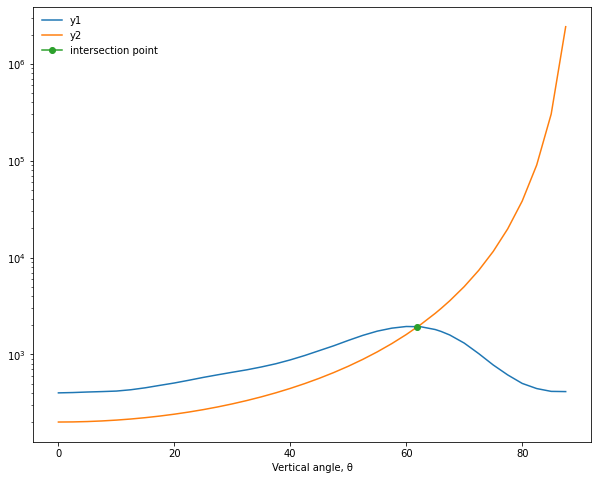

In [95]:
plot_intersection(x,y1,y2, xc, yc)

In [96]:
SC_0_180 = np.round(np.tan(xc*np.pi/180)[0][0],2)*2
SC_0_180

3.74

#### 7.2 Spacing Criterion (90-270)

In [97]:
y1, y2 = prep(90, cd_sc, x,2)
xc, yc = interpolated_intercept(x, y1, y2)

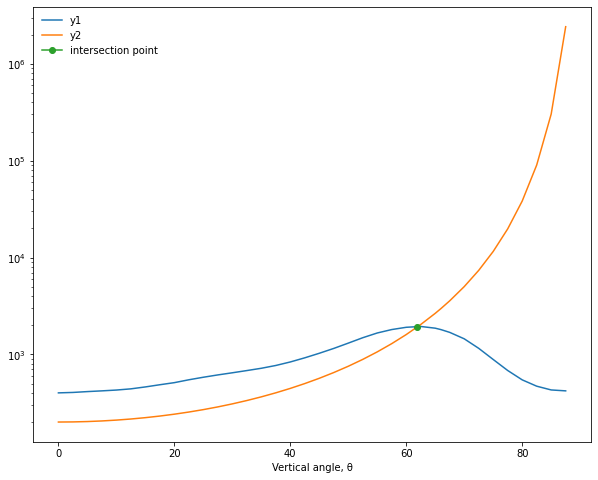

In [98]:
plot_intersection(x, y1, y2, xc, yc)

In [99]:
SC_90_270 = np.round(np.tan(xc*np.pi/180)[0][0],2)*2
SC_90_270

3.74

#### 7.3 Spacing Criterion (diagonal)

In [100]:
# y1, y2 = prep(45, cd_sc, x,4)
# xc, yc = interpolated_intercept(x, y1, y2)
# plot_intersection(x, y1, y2, xc, yc)

In [101]:
# SC_diagonal = np.round(np.tan(xc*np.pi/180)[0][0]*2*np.sin(45*np.pi/180),2)
# SC_diagonal

In [102]:
print(f'Spacing Criterion (0-180): {SC_0_180}')
print(f'Spacing Criterion (90-270): {SC_90_270}')

Spacing Criterion (0-180): 3.74
Spacing Criterion (90-270): 3.74
